# Twitter Sentiment Analysis

**Installalling the required packages**

In [2]:
#!pip install scipy nltk seaborn textblob

**Importing the required packages**

In [3]:
import numpy as np
import pandas as pd
import json, nltk
import matplotlib.pyplot as plt

import seaborn as sns
nltk.download('wordnet')  

%matplotlib inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\finnocenti\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


**Reading data from CSV file**

N.B. The dataset is not in "UTF-8" encoding

In [4]:
total_data = pd.read_csv("datasets/Twitter_train.csv", encoding="ISO-8859-1")

**Showing the data**

In [5]:
#this opinion is used for setting Pandas DataFrame to show non-truncated table
pd.set_option('display.max_colwidth', -1)

total_data.head()

C:\Users\finnocenti\AppData\Local\Temp\ipykernel_39736\2783862136.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL friend.............
1,2,0,I missed the New Moon trailer...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
4,5,0,i think mi bf is cheating on me!!! T_T


**Taking column names into variables**

In [6]:
tweet = total_data.columns.values[2]
sentiment = total_data.columns.values[1]

In [7]:
tweet, sentiment

('SentimentText', 'Sentiment')

## Step 1: Preprocessing

* **Converting every tweets to lower case**
* **Removing punctuations, numbers and special characters**
* **Converting more than 2 letter repetitions to 2 letter ( example (wooooooow --> woow))**
* **Removing extra spaces**
* **Removing Twitter username**
* **Removing URLs**
* **Emoji analysis**
* **Handling the contractions words: " can't " >> " can not ", " won't " >> " will not "**
* **Tokenization (or split with space)**
* **(Optional) Removing stopwords**
* **(Optional) Stemming or Lemmatization**

**Importing Contractions**

In [8]:
with open('assets/contractions.json', 'r') as f:
    contractions_dict = json.load(f)
contractions = contractions_dict['contractions']

In [9]:
contractions

{"ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

**Function for emoji classifications**

In [10]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negetiveemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negetiveemoji ', tweet)
    return tweet


**Function for tweet processing**

In [11]:
import re #for using regular expressions

def process_tweet(tweet):
    tweet = tweet.lower()                                             # Lowercases the string
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    
    #simple tokenization using split()
    for word in tweet.split():
        if word.lower() in contractions:
            tweet = tweet.replace(word, contractions[word.lower()])   # Replaces contractions
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)    # Convert more than 2 letter repetitions to 2 letter (e.g., cooool)
    tweet = re.sub(r"\s+", " ", str(tweet))      # Replaces extra spaces with a single space    
    return tweet


**Processing all the tweets**

We can make a new column in the dataframe for side by side comparison of processed tweets vs original tweets

In [12]:
total_data['processed_tweet'] = np.vectorize(process_tweet)(total_data[tweet])

total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer
2,3,1,omg its already 7:30 :O,omg its already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t
5,6,0,or i just worry too much?,or just worry too much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number


## Other NL text processing (optional):
* **stopword removal**
* **stemming or lemmatization**

**Example of stopword removal**

In [19]:
from  nltk import stopwords

ImportError: cannot import name 'stopwords' from 'nltk' (c:\Users\finnocenti\Anaconda3\envs\Social-Analytics\lib\site-packages\nltk\__init__.py)

In [21]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\finnocenti\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [22]:
def stopwords_removal(tweet):
    from nltk.corpus import stopwords
    stopwords = stopwords.words("english")
    
    cleaned_tweet = ""

    for w in tweet.split():
        if w not in stopwords:
            cleaned_tweet = cleaned_tweet +" "+w

    return cleaned_tweet


In [24]:
processed_tweet = total_data.columns.values[3]

total_data['clean_tweet'] = np.vectorize(stopwords_removal)(total_data[processed_tweet])

total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet,clean_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend,sad apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer,missed new moon trailer
2,3,1,omg its already 7:30 :O,omg its already,omg already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins,omgaga im soo im gunna cry dentist since suposed get crown put mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t,think mi bf cheating t_t
5,6,0,or i just worry too much?,or just worry too much,worry much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight,sunny work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already,handed uniform today miss already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number,hmm wonder number


**Example of stemming**

In [25]:
def tweet_stemmer(tweet):
    from nltk.stem import SnowballStemmer

    snowball = SnowballStemmer("english")

    stemmed_tweet = ""
    for w in tweet.split():
        stemmed_tweet = stemmed_tweet +" "+snowball.stem(w)

    return stemmed_tweet

In [26]:
clean_tweet = total_data.columns.values[4]

total_data['clean_stemmed_tweet'] = np.vectorize(tweet_stemmer)(total_data[clean_tweet])

total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet,clean_tweet,clean_stemmed_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend,sad apl friend,sad apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer,missed new moon trailer,miss new moon trailer
2,3,1,omg its already 7:30 :O,omg its already,omg already,omg alreadi
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins,omgaga im soo im gunna cry dentist since suposed get crown put mins,omgaga im soo im gunna cri dentist sinc supos get crown put min
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t,think mi bf cheating t_t,think mi bf cheat t_t
5,6,0,or i just worry too much?,or just worry too much,worry much,worri much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin,juusst chillin,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight,sunny work tomorrow negetiveemoji tv tonight,sunni work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already,handed uniform today miss already,hand uniform today miss alreadi
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number,hmm wonder number,hmm wonder number


**Example of Lemmatization**

In [27]:
def tweet_lemmatizer(tweet):
    from nltk import WordNetLemmatizer

    lemma = WordNetLemmatizer()
    
    lemmatized_tweet = ""
    
    for w in tweet.split():
        lemmatized_tweet = lemmatized_tweet+" "+lemma.lemmatize(w, pos='v')
    return lemmatized_tweet

In [29]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\finnocenti\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [30]:
clean_tweet = total_data.columns.values[4]

total_data['clean_lemmatized_tweet'] = np.vectorize(tweet_lemmatizer)(total_data[clean_tweet])

total_data.head(10)

,ItemID,Sentiment,SentimentText,processed_tweet,clean_tweet,clean_stemmed_tweet,clean_lemmatized_tweet
0,1,0,is so sad for my APL friend.............,is so sad for my apl friend,sad apl friend,sad apl friend,sad apl friend
1,2,0,I missed the New Moon trailer...,missed the new moon trailer,missed new moon trailer,miss new moon trailer,miss new moon trailer
2,3,1,omg its already 7:30 :O,omg its already,omg already,omg alreadi,omg already
3,4,0,.. Omgaga. Im sooo im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...,omgaga im soo im gunna cry ve been at this dentist since was suposed just get crown put on mins,omgaga im soo im gunna cry dentist since suposed get crown put mins,omgaga im soo im gunna cri dentist sinc supos get crown put min,omgaga im soo im gunna cry dentist since suposed get crown put mins
4,5,0,i think mi bf is cheating on me!!! T_T,think mi bf is cheating on me t_t,think mi bf cheating t_t,think mi bf cheat t_t,think mi bf cheat t_t
5,6,0,or i just worry too much?,or just worry too much,worry much,worri much,worry much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,juusst chillin,juusst chillin,juusst chillin,juusst chillin
7,8,0,Sunny Again Work Tomorrow :-| TV Tonight,sunny again work tomorrow negetiveemoji tv tonight,sunny work tomorrow negetiveemoji tv tonight,sunni work tomorrow negetiveemoji tv tonight,sunny work tomorrow negetiveemoji tv tonight
8,9,1,handed in my uniform today . i miss you already,handed in my uniform today miss you already,handed uniform today miss already,hand uniform today miss alreadi,hand uniform today miss already
9,10,1,hmmmm.... i wonder how she my number @-),hmm wonder how she my number,hmm wonder number,hmm wonder number,hmm wonder number


## Step 2: Feature extraction (vectorization)

Machine learning algorithms need to work with numbers. We have to convert the textual data into numbers without losing much of the information. 

One way to do such transformation is *Bag-Of-Words (BOW)* which gives a number to each word.


**CountVectorizer** it counts the number of words in the document. It converts a collection of text documents to a matrix where the elements are the number of occurences of each word in the document.

**CountVectorizer** gives equal weightage to all the words, i.e., a word weigth is equal to 1 if it is present in that doc else 0. 

In [31]:
tweets = total_data['clean_lemmatized_tweet']

In [32]:
len(tweets)

99989

In [34]:
#Import required libraries:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram (single words) and Bigram (two consecutive words)
final_vectorized_data = count_vectorizer.fit_transform(tweets)  



In [36]:
#print(final_vectorized_data.toarray())

print(type(final_vectorized_data))

<class 'scipy.sparse.csr.csr_matrix'>


Alternatively, we can use **TF-IDF**. 

**TF-IDF** (*Term-Frequency-Inverse-Document Frequency*) is different from CountVectorizer as it weights down the common words occuring in almost all the documents of the collection, while it gives more importance to the words that appear in a subset of documents (more discriminative terms). TF-IDF works by considering how frquent is the word in the doc **(TF)** and penalising these common words that appear in most of the documents of the collection **(IDF)**. The assumption is that *rare terms are awarded as they are more informative than frequent terms*

![](assets/tfidf.png)


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer 

tf_idf_vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1,3))
final_vectorized_data_TFIDF = tf_idf_vectorizer.fit_transform(tweets)


## Step 3: Sentiment Classification

#### (3.1) Splitting dataset into train and test sets:
* **train set:** for training the model 
* **test set:** for testing the model's accuracy

In [38]:
#with CountVectorizer
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data, total_data[sentiment],
                                                    test_size=0.2, random_state=69)  
#test set's size is 20% of the whole dataset
#random_state: Controls the shuffling applied to the data before applying the split.

#with TFIDF
#X_train, X_test, y_train, y_test = train_test_split(final_vectorized_data_TFIDF, total_data[sentiment], 
#                                                    test_size=0.2, random_state=69)  


**Printing splitted dataset sizes**

In [39]:
print("X_train_shape: ",X_train.shape)
print("X_test_shape: ",X_test.shape)
print("y_train_shape: ",y_train.shape)
print("y_test_shape: ",y_test.shape)

X_train_shape:  (79991, 403507)
X_test_shape:  (19998, 403507)
y_train_shape:  (79991,)
y_test_shape:  (19998,)


#### (3.2) Training the model and predicting with Naive Bayes

Popular classifiers based on Naive Bayes are:

* **Bernoulli Naive Bayes**
* **Gaussian Naive Bayes classifier**
* **Multinomial Naive Bayes**

We are going to user Multinomial Naive Bayes

**Bayes theorem:**
![](assets/bayes_formula.jpg)

**Multinomial Naive Bayes classifier**

In [40]:
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)

#### (3.3) Analyzing the results

**Print Confusion matrix**

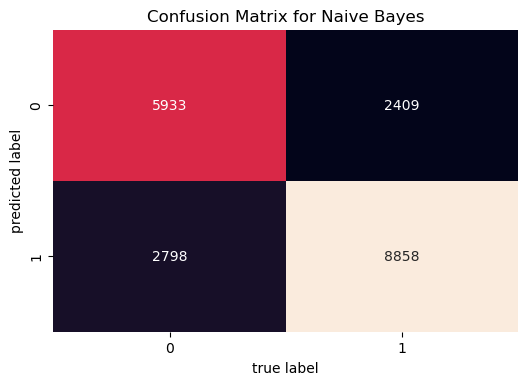

In [41]:
from sklearn.metrics import confusion_matrix

plt.figure(dpi=100)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig("assets/confusion_matrix.png")
plt.show()

**Computing the accuracy of our prediction**

Accuracy = (TP + TN)/(TP + FP + TN + FN)

In [42]:
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes:", score_naive)

Accuracy with Naive-bayes: 0.7396239623962396


**Precision, recall, and accuracy**

These are the standard metrics used to evaluate the performance of a classifier.

* **Precision:** measures how many docs are predicted correctly as belonging to a given category out of all of the docs that are predicted (correctly and incorrectly) as belonging to the category. P = TP / (TP + FP)

* **Recall:** measures how many texts were predicted correctly as belonging to a given category out of all the texts that should have been predicted as belonging to the category. We also know that the more data we feed our classifiers with, the better recall will be. R = TP / (TP + FN)

* **Accuracy:** measures how many texts were predicted correctly (both as belonging to a category and not belonging to the category) out of all of the texts in the corpus. A = TP + TN / (TP + FP + TN + FN)

**N.B. precision and recall are used to measure performance since accuracy alone does not say much about how good or bad a classifier is**

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_naive))

              precision    recall  f1-score   support

           0       0.71      0.68      0.70      8731
           1       0.76      0.79      0.77     11267

    accuracy                           0.74     19998
   macro avg       0.74      0.73      0.73     19998
weighted avg       0.74      0.74      0.74     19998



#### (3.4) Visualizing results

**Drawing ROC curve**

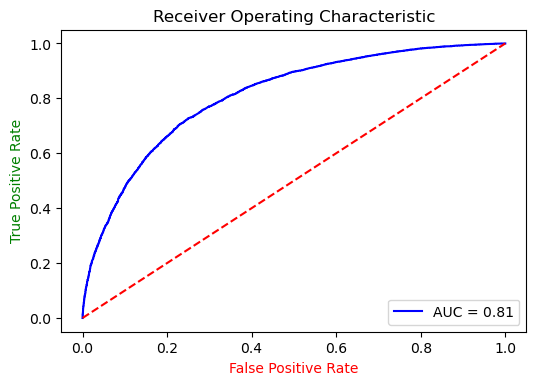

In [44]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# calculate the fpr and tpr for all thresholds of the classification
probs = model_naive.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(dpi=100)                       # to plot high quality graph
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate', color='g')
plt.xlabel('False Positive Rate', color='r')
plt.savefig("assets/ROC_curve.png")
plt.show()

**The Area Under the Curve is greater than `0.80` and this with real life data is not bad!**

## Conclusions

The original version of the tutorial also compared the results achieved with different approaches for vectorization: CountVectorizer vs. TF-IDF and with different approaches for tweet processing: *text normalization* (None vs. Stemming vs. Lemmatizing) and with or without *stopword removal*.

In *Table 1*, we can see the hierarchy of the accuracy rate for 3 combinations (vectorizer, stopwords, normalization). Sorted in decreasing order of accuracy. 

#### Results

It seems that the best combination for sentiment analysis with the Twitter dataset is using
* **Without normalization (no Stemming or Lemmatizing)**
* **Without stopwords removal**
* **Count Vectorizer**
* **Unigrams and Bigrams**

**Leaderboard Highest : 0.79249**<br>
**Naive model : 0.76788**

Usually, for document analysis the best combination will include lemmatization, stopwords removal, etc. In sentiment analysis, we can see that they aren't providing edge over the raw data


##### Table 1

| Normalization 	| Stop Words 	| Vectorizer 	|      Accuracy      	|
|:-------------:	|:----------:	|:----------:	|:------------------:	|
|     None        	|     No     	|    Count   	| 0.7601260126012601 	|
|  Lemmatizing  	|     No     	|    Count   	|  0.757025702570257 	|
|    Stemming   	|     No     	|    Count   	|  0.755025502550255 	|
|  Lemmatizing  	|     Yes    	|    Count   	| 0.7483748374837483 	|
|     None        	|     No     	|   Tf-Idf   	| 0.7480748074807481 	|
|    Stemming   	|     Yes    	|    Count   	| 0.7477747774777478 	|
|  Lemmatizing  	|     Yes    	|   Tf-Idf   	| 0.7456245624562456 	|
|    Stemming   	|     No     	|   Tf-Idf   	| 0.7435743574357436 	|
|  Lemmatizing  	|     No     	|   Tf-Idf   	| 0.7403740374037404 	|
|    Stemming   	|     Yes    	|   Tf-Idf   	| 0.7383738373837384 	|

## Acknowledgements

This tutorial is inspired by 
* **GitHub link: [twitter sentiment analysis](https://github.com/Gunjan933/twitter-sentiment-analysis/blob/master/twitter-sentiment-analysis.ipynb)**

* **Report link: [twitter sentiment analysis project report](https://github.com/Gunjan933/twitter-sentiment-analysis/blob/master/report/Twitter_setiment_analysis_project_report.pdf)**


#### Dataset is taken from
* **[Kaggle Twitter dataset](https://www.kaggle.com/c/twitter-sentiment-analysis2/data)**


#### Suggested Readings
* **[Everything You Need to Know about Sentiment Analysis](https://monkeylearn.com/sentiment-analysis/)**
 
* **[Everything You Need to Know about the methods for dealing with text](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/)**

* **[Towards Data Science](https://towardsdatascience.com/creating-the-twitter-sentiment-analysis-program-in-python-with-naive-bayes-classification-672e5589a7ed)**

* **[Analytics Vidya](https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/)**

* **[Medium](https://medium.com/@martinpella/naive-bayes-for-sentiment-analysis-49b37db18bf8)**

* **[Stackabuse](https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/)**

* **[Geeksforgeeks](https://www.geeksforgeeks.org/graph-plotting-in-python-set-1/)**

## Other Analysis on positive/negative tweets

**Showing statistics**

In [29]:
total_data[sentiment]

0        0
1        0
2        1
3        0
4        0
        ..
99984    0
99985    1
99986    0
99987    1
99988    1
Name: Sentiment, Length: 99989, dtype: int64

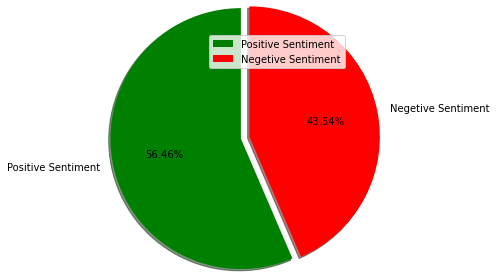

In [45]:
sentiments = ['Positive Sentiment', 'Negetive Sentiment'] 
#1 for positive and 0 for negative sentiment
slices = [(total_data[sentiment] != 0).sum(), (total_data[sentiment] == 0).sum()] 
colors = ['g', 'r'] 
plt.pie(slices, labels = sentiments, colors=colors, startangle=90, shadow = True,
        explode = (0, 0.1), radius = 1.5, autopct = '%1.2f%%') 
plt.legend()
plt.show() 

## Subjectivity and polarity with textblob

In [46]:
from textblob import TextBlob

#Find out positive tweets

positive_tweets = []

for i in range(0, len(total_data['clean_tweet'])):
    text = total_data['clean_tweet'][i]
    text_blob = TextBlob(text)
    #text opinionated or not
    subjectivity = text_blob.subjectivity
    #if text opinionated --> negative, positive
    polarity = text_blob.polarity
    
    
    if (subjectivity > 0.5) and polarity > 0.5:
        positive_tweets.append(text)
    

In [47]:
#print only 10 of them

for i in range(0, 10):
    print(positive_tweets[i])

 cut beard growing well year gonna start happy meantime
 sox floyd great relievers need scolding
 proud
 think may friendly lol well
 wish could go beach negetiveemoji would great see amp
 got home got see friend zahra seen since graduated makes happy
 lt good timess
 hot choco best
 bueno good bye good night
 amazing night day amp night hi twits miss guys


## Word distributions

**Function for preprocessing tweets**

In [48]:
def process_text(tweets):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    
    stopwords = stopwords.words("english")
    
    tokens = []
    for tweet in tweets:
        tweet = tweet.lower()
        toks = word_tokenize(tweet)
        toks = [t for t in toks if t not in stopwords]
        tokens.extend(toks)
    
    return tokens

**Example for positive words**

In [50]:
 nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\finnocenti\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [51]:
pos_tokens = process_text(positive_tweets)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(40)

[('good', 3238),
 ('lol', 2726),
 ('great', 1288),
 ('awesome', 938),
 ('happy', 896),
 ('nice', 789),
 ('day', 739),
 ('love', 617),
 ('welcome', 566),
 ('like', 541),
 ('know', 485),
 ('hope', 471),
 ('get', 445),
 ('morning', 431),
 ('one', 417),
 ('see', 408),
 ('well', 405),
 ('amp', 356),
 ('time', 336),
 ('amazing', 326),
 ('oh', 318),
 ('would', 316),
 ('got', 313),
 ('think', 305),
 ('luck', 304),
 ('im', 293),
 ('beautiful', 290),
 ('go', 281),
 ('today', 272),
 ('night', 256),
 ('yeah', 253),
 ('work', 252),
 ('birthday', 251),
 ('thank', 247),
 ('going', 227),
 ('hey', 223),
 ('twitter', 217),
 ('still', 216),
 ('sounds', 215),
 ('na', 208)]

**Plotting the distribution**

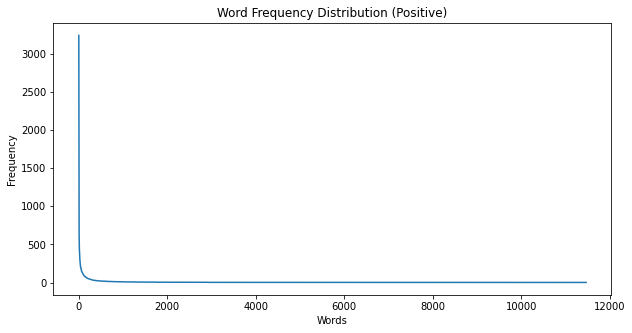

In [35]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

**Log-log plot**

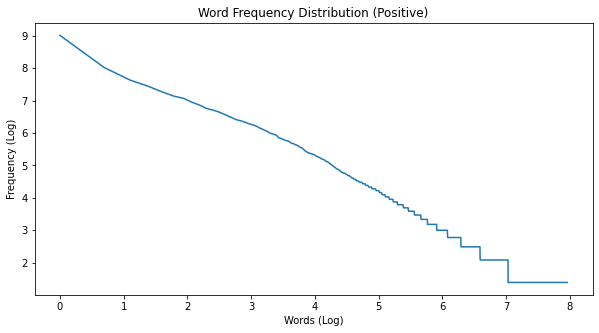

In [36]:
import math

y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

## Some ideas for a practical project

Given the tutorial on sentiment analysis using Twitter data, you can choose one of these possible projects:
* **Project proposal 1:** Repeat the tutorial with the Twitter dataset using different approaches for text processing or 
    vectorization, then compare the results with the ones reported in Table 1 (see Conclusions of the tutorial) 
    
* **Project proposal 2:** Repeat the tutorial with the Twitter dataset varying the classification approach and compare the results with Multinomial Naive Bayes Classifier 
     
* **Project proposal 3:** Repeat the tutorial on a different dataset (e.g., reviews) varying the approaches for preprocessing and classification, then compare the results achieved. To read the reviews dataset you can used the example for reading data from Clothing_review.csv 
    
* **Project proposal 4:** Repeat the tutorial and extend the analysis of positive/negative tweets (e.g., using TextBlob check if the positive tweets detected by polarity >0.5 are actually labeled as positive in the dataset) 

* **Project proposal 5:** Repeat the tutorial and extend the analysis of positive/negative tweets by creating a vocabulary of positive/negative words (e.g., which positive/negative words are found in tweets classified as positive/negative? Which is their distribution?) 



**Example on how to read the review dataset**

In [37]:
df = pd.read_csv('datasets/Clothing_review.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


In [38]:
#Drop unnecessary columns

df = df.drop(['Title', 'Positive Feedback Count', 'Unnamed: 0', ], axis=1)
df.dropna(inplace=True)

df.head()

,Clothing ID,Age,Review Text,Rating,Recommended IND,Division Name,Department Name,Class Name
0,767,33,Absolutely wonderful - silky and sexy and comfortable,4,1,Initmates,Intimate,Intimates
1,1080,34,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,General,Dresses,Dresses
2,1077,60,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,General,Dresses,Dresses
3,1049,50,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,General Petite,Bottoms,Pants
4,847,47,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,General,Tops,Blouses


**Computing the polarity based on the rating**

In [39]:
df['Polarity_Rating'] = df['Rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

df_temp = df[['Review Text', 'Polarity_Rating']]

df_temp.head()



,Review Text,Polarity_Rating
0,Absolutely wonderful - silky and sexy and comfortable,Positive
1,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",Positive
2,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",Neutral
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",Positive
4,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,Positive
